In [13]:
CLEAR_NAME_CACHE = False

In [22]:
import requests
import base64
import json
import os
import datetime as dt
from datetime import datetime, date
import pytz
import diskcache
import urllib.parse
from matplotlib import pyplot as plt
plt.rcParams.update({'font.family': 'Noto Sans CJK JP'})
import numpy as np
from operator import itemgetter, attrgetter
import pandas as pd
from pdb import set_trace

# Functionality

## Utils

In [16]:
def now():
    return datetime.utcnow().replace(tzinfo=pytz.utc)

def filter_dict(d, keys):
    return list(map(lambda x: {k: v for k, v in x.items() if k in keys}, d))

## Setting up Toggl API
Note that a safe API request rate is 1 request per second.

In [15]:
project_dir = os.path.abspath('')

API_version = 'v9'
prefix = f"https://api.track.toggl.com/api/"

API = {
    "time_entries" :          prefix + "v8" + "/time_entries",
    "get_current_time_entry": prefix + API_version + "/me/time_entries/current", 
    "me_info" :               prefix + API_version + "/me",
    "projects_me" :           prefix + API_version + "/me/projects",
    "projects_ws" :           prefix + API_version + "/workspaces/4143224/projects",
    "workspaces" :            prefix + API_version + "/workspaces",
}

with open(f"{project_dir}/api_key.txt") as f:
    API_token = f"{f.read()}:api_token"
API_token_base64 = base64.b64encode(API_token.encode('ascii')).decode('ascii')

project_id_names = diskcache.Cache(f"{project_dir}/project_id_names.cache")
if CLEAR_NAME_CACHE:
    project_id_names.clear()

In [5]:
def fetch(url, headers={}):
    headers={"Content-Type": "application/json", 
                                    "Host": "api.track.toggl.com",
                                    "authorization": f"Basic {API_token_base64}", 
                                    **headers}
    r = requests.get(url, headers=headers)
    return json.loads(r.content.decode('utf-8'))

def fetch_project(project_id):
    return fetch(f"{API['projects_ws']}/{project_id}")

In [20]:
def update_current_time_entry_duration(time_entry):
    time_entry["duration"] = (datetime.utcnow().replace(tzinfo=pytz.utc) - \
                              time_entry["start"]).seconds
    return time_entry

def get_time_entries(start_date, end_date):
    date_to_str = lambda date: date.strftime('%Y-%m-%dT%H:%M:%S') + f'{date.strftime("%z")[:3]}:{date.strftime("%z")[3:]}'
    url_exts = '?'
    url_exts += f"start_date={urllib.parse.quote(date_to_str(start_date))}"
    url_exts += f"&end_date={urllib.parse.quote(date_to_str(end_date))}"
    time_entries = fetch(API['time_entries'] + url_exts)
        
    time_entries = [x for x in time_entries if 'pid' in x]
        
    for time_entry in time_entries:
        project_id = time_entry['pid']
        if project_id not in project_id_names:
            project_id_names[project_id] = fetch_project(project_id)
        time_entry['project_name'] = project_id_names[project_id]['name']
        
        time_entry['start'] = datetime.fromisoformat(time_entry['start'])
        if 'stop' in time_entry:
            time_entry['stop'] = datetime.fromisoformat(time_entry['stop'])
        if time_entry['duration'] < 0:
            time_entry = update_current_time_entry_duration(time_entry)        
    return time_entries

def get_day_entries(date):
    # TODO
    start_date = datetime.fromisoformat(f'{str(date)}T01:00:00+00:00')
    end_date = datetime.fromisoformat(f'{str(date)}T23:59:59+00:00')
    return get_time_entries(start_date, end_date)

def get_todays_entries():
    return get_day_entries(date.today())

def get_week_entries():
    pass

def get_month_entries():
    pass

def get_last_n_days(n):
    entries = []
    for i in range(n):
        entries.append(get_day_entries(date.today() - dt.timedelta(n-1-i)))
    return entries

def get_all_data():
    pass 

## Time entry processing

In [7]:
def accumulate(entries):
    times = {}
    for entry in entries:
        times[entry['project_name']] = times.get(entry['project_name'], 0) + entry['duration']
    return sorted(list(times.items()), key=itemgetter(1))

def n_acc(n, sleep=False):
    entries = get_last_n_days(n)
    entries = list(map(accumulate, entries))
    if not sleep:
        entries = [[(k,v) for k,v in x if k != 'sleep睡眠'] for x in entries]
    return entries

## Plotting Logic

In [18]:
def pie(ax, data):
    name, size = [x[0] for x in data], [x[1] for x in data]
    ax.pie(size, labels=name, autopct='%1.1f%%',
            shadow=True, startangle=180-45, explode=0.05 * np.random.rand(len(data)))
    return ax

def bar(ax, data):
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    for j, d in enumerate(data): 
        height = 0
        cmap = plt.cm.get_cmap('hsv', len(d))
        inverse_shrink = 5
        for i, (x,y) in enumerate(reversed(d)):
            y_scaled = y/(60*60)
            new_height = height + y_scaled
            ax.bar(j, height=y_scaled, tick_label='yo', alpha=1, color=cmap(i), bottom=height, edgecolor='black')
            ax.text(j, new_height, str(dt.timedelta(seconds=y)) + ' ' + x, va='top', ha='center', size=8)
            height = new_height
    return ax

# Visualisations

In [17]:
# Fetch the data
entries = get_todays_entries()
acc = accumulate(entries)
acc_nosleep = [(k,v) for k, v in acc if k != 'sleep睡眠']
acc_7 = n_acc(7, True)
acc_7_nosleep = n_acc(7)

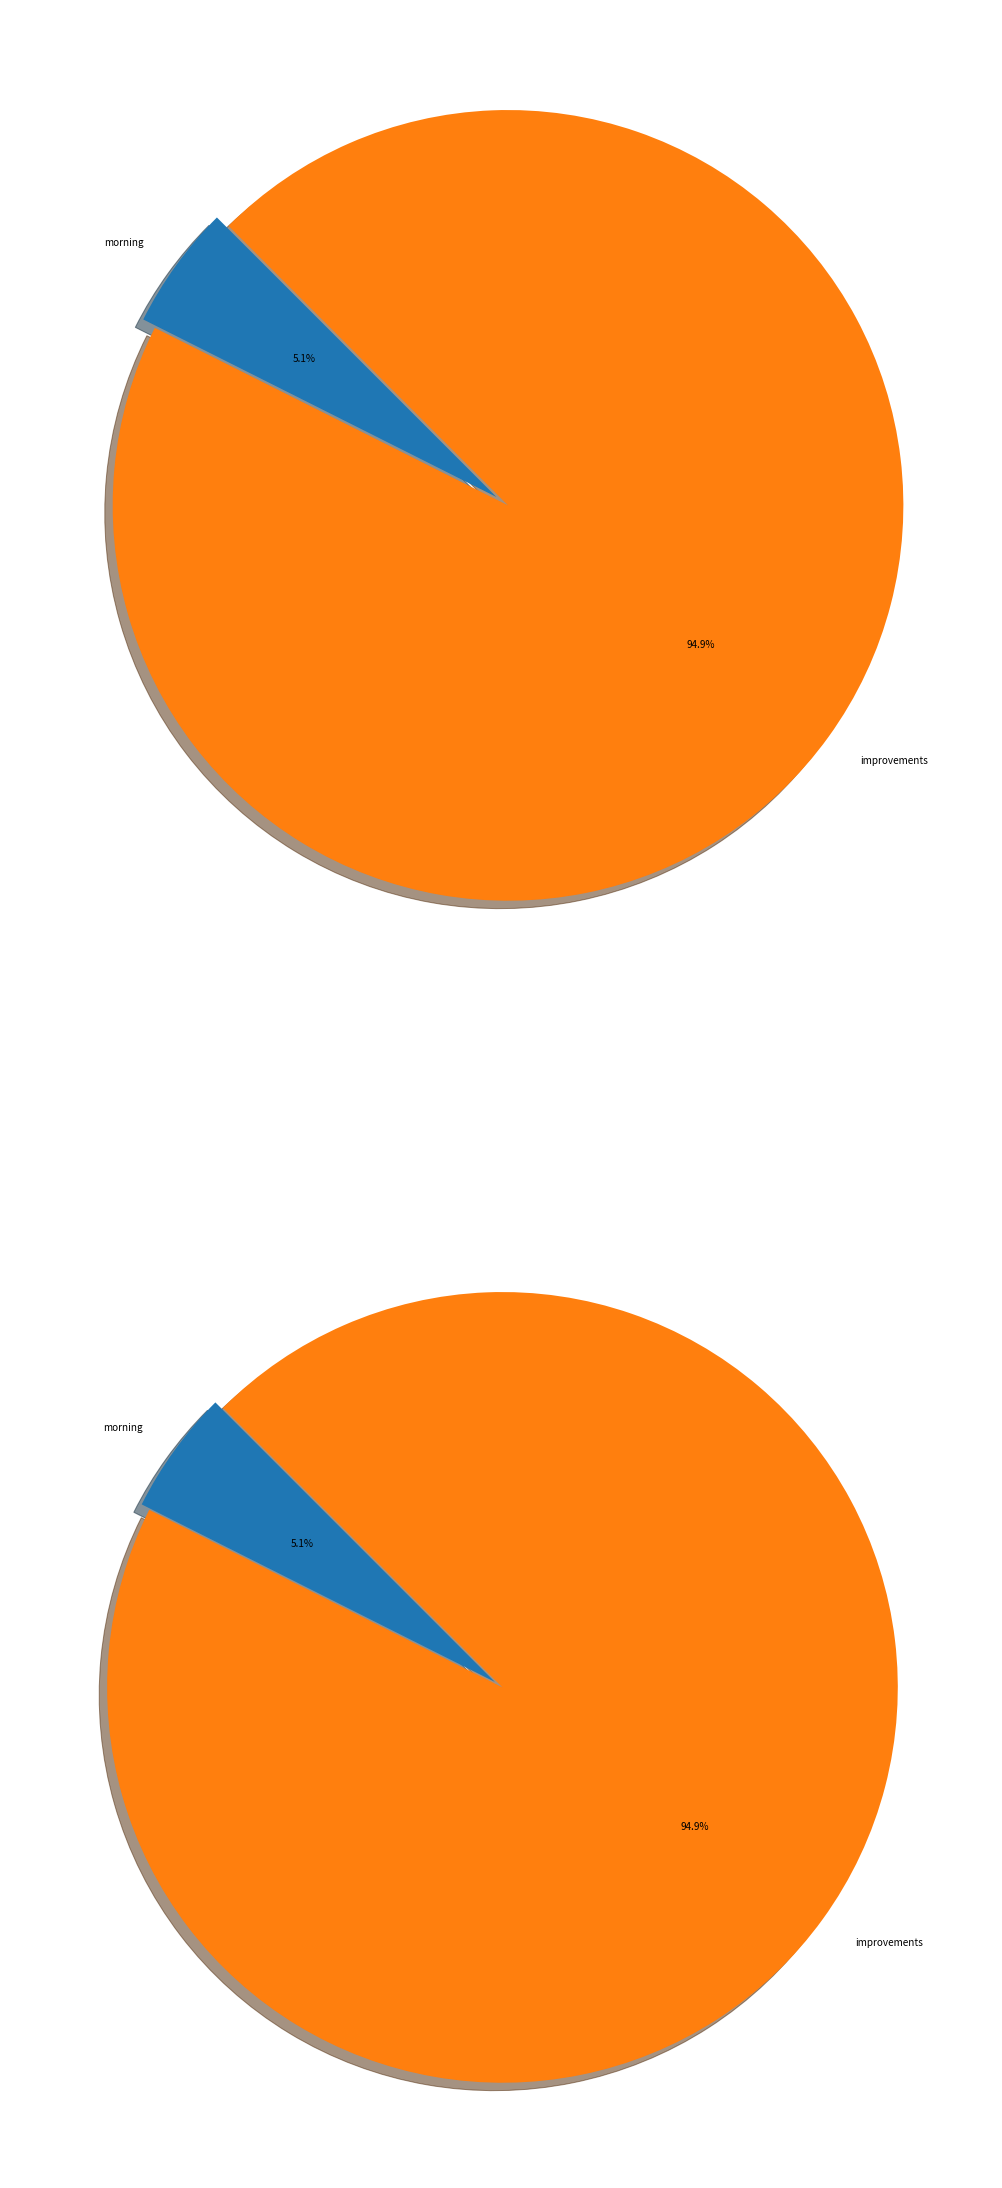

In [23]:
#pies
fig, axs = plt.subplots(2,1,figsize=(20,40))
pie(axs[0], acc)
pie(axs[1], acc_nosleep)
plt.show()

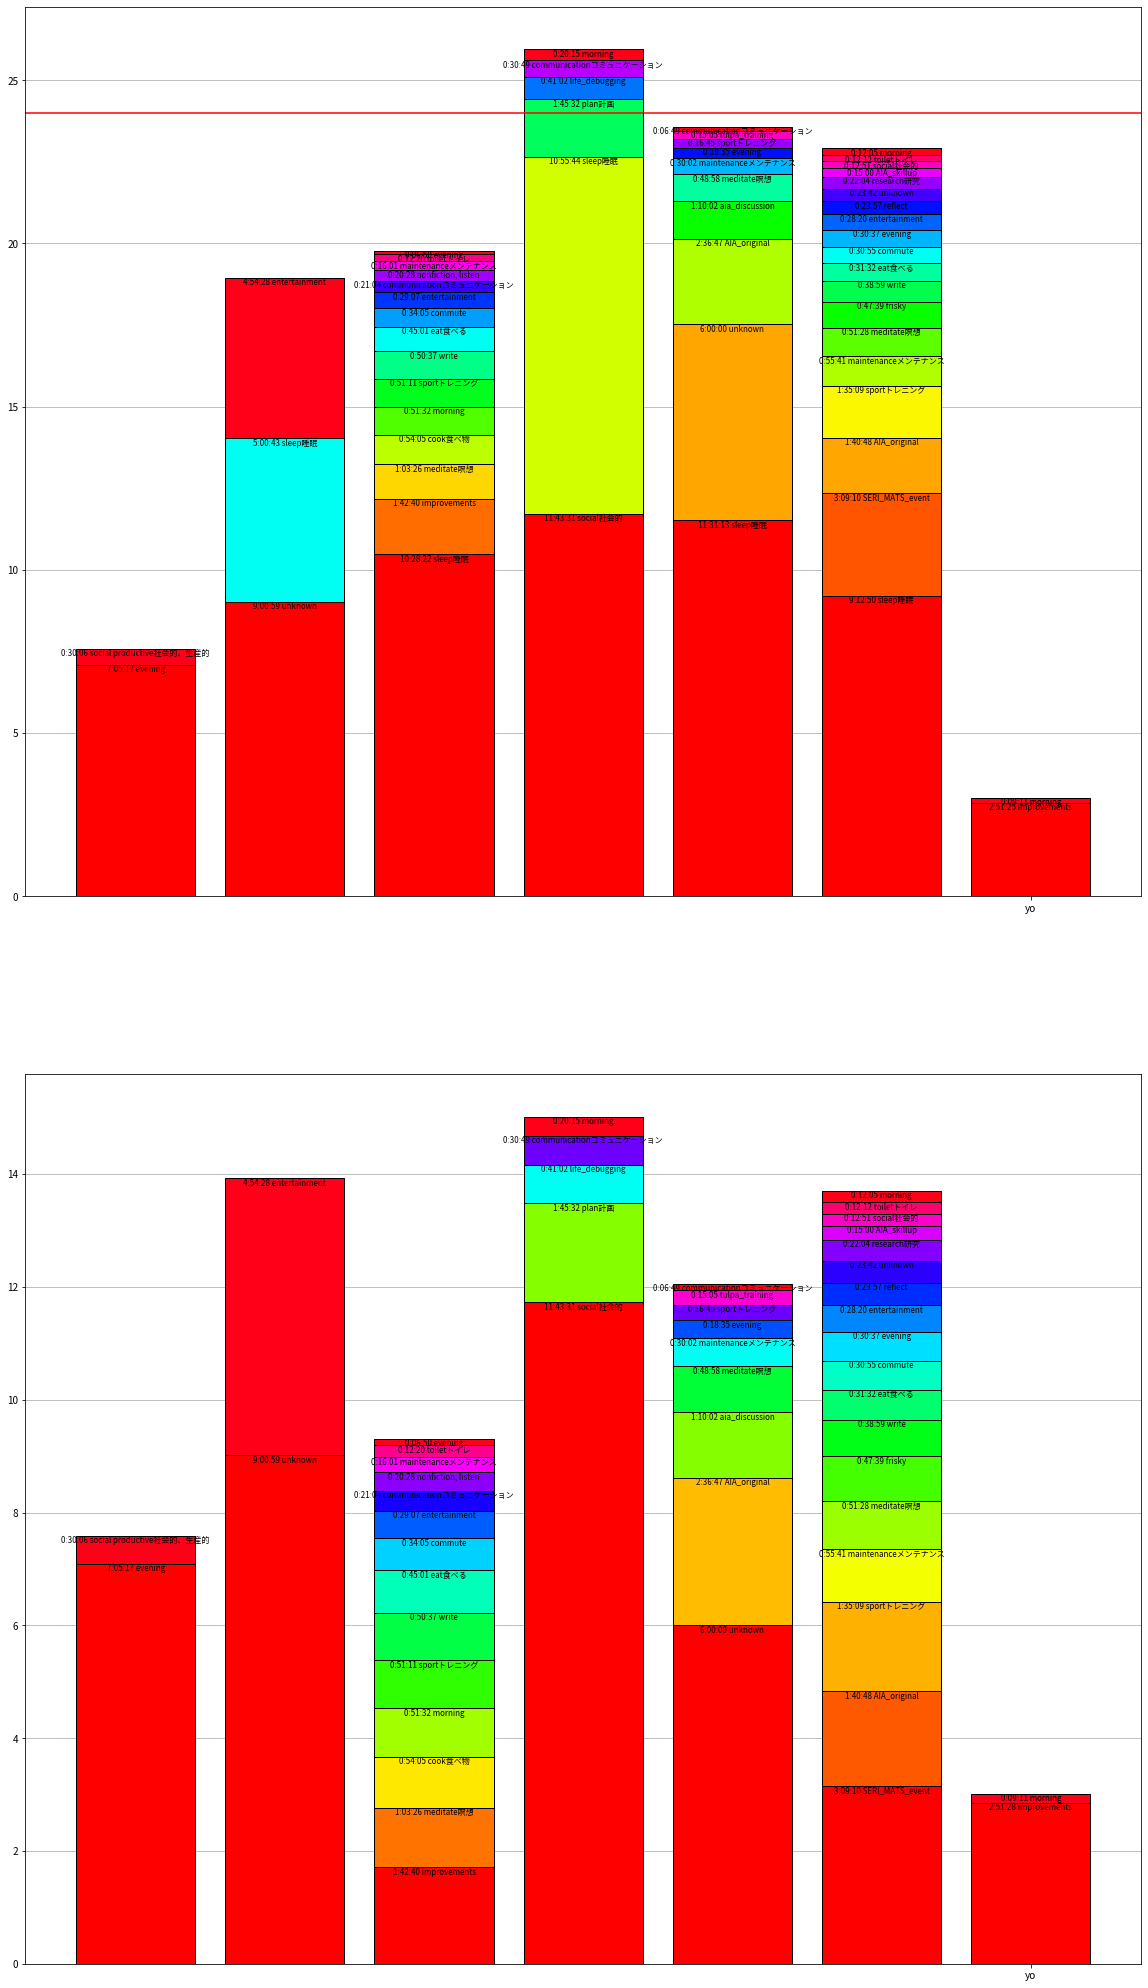

In [24]:
# Bars
fig, axs = plt.subplots(2,1,figsize=(20,36))
bar(axs[0], acc_7)
axs[0].axhline(24, color='red')
bar(axs[1], acc_7_nosleep)
plt.show()